In [13]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt


In [2]:
dir_save_pixc = 'data/jinsha_river/pixc'
path_dianchi_vec = 'data/jinsha_river/dianchi_vector.gpkg'


In [3]:
## Check original .nc raster file.
paths_file = [os.path.join(dir_save_pixc, file) for file in os.listdir(dir_save_pixc) if 'PIXC_' in file and '.nc' in file]
print(paths_file[0])
pixc_nc = xr.open_dataset(paths_file[0], group='pixel_cloud')
pixc_nc


data/jinsha_river/pixc/SWOT_L2_HR_PIXC_010_383_202R_20240207T162552_20240207T162603_PIC0_01.nc


<xarray.Dataset> Size: 934MB
Dimensions:                                (points: 3383490, complex_depth: 2,
                                            num_pixc_lines: 3285)
Coordinates:
    latitude                               (points) float64 27MB ...
    longitude                              (points) float64 27MB ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 27MB ...
    range_index                            (points) float64 27MB ...
    interferogram                          (points, complex_depth) float32 27MB ...
    power_plus_y                           (points) float32 14MB ...
    power_minus_y                          (points) float32 14MB ...
    coherent_power                         (points) float32 14MB ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB ...
    data_window_first_valid                (num_pixc_lines) float64 26kB ...
    data_window_last_valid                 (num_pixc_lines) float64 26kB ...
    data_window_first_cross_track          (num_pixc_lines) float32 13kB ...
    data_window_last_cross_track           (num_pixc_lines) float32 13kB ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3285
    interferogram_size_range:    6395
    looks_to_efflooks:           1.554334966739449
    num_azimuth_looks:           7.0
    azimuth_offset:              3

(55520,)


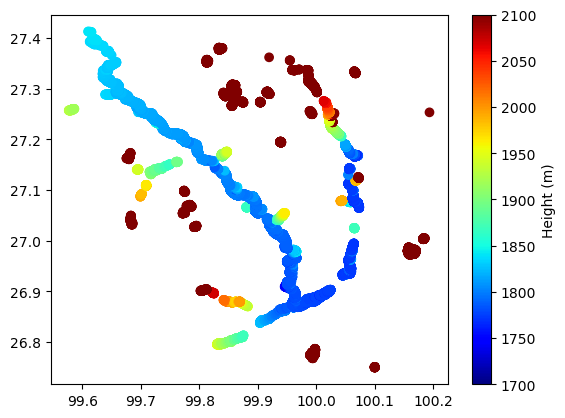

In [20]:
# mask to get good water pixels
mask = np.where(np.logical_and(pixc_nc.classification > 2, pixc_nc.geolocation_qual <= 64))
print(mask[0].shape)
plt.scatter(x=pixc_nc.longitude[mask], y=pixc_nc.latitude[mask], c=pixc_nc.height[mask], cmap='jet')
plt.clim((1700, 2100))
plt.colorbar().set_label('Height (m)')


In [7]:
def toslant(pixc, key='height'):
    az = pixc.azimuth_index.astype(int)
    rng = pixc.range_index.astype(int)
    out = np.zeros((pixc.interferogram_size_azimuth + 1, pixc.interferogram_size_range + 1)) + np.nan
    # handle complex interferogram
    if key=='interferogram':
        out = out.astype('complex64')
        var = pixc[key][:,0] + 1j * pixc[key][:,1]
    else:
        var = pixc[key]
    out[az, rng] = var
    return out



In [8]:
height = toslant(pixc_nc, key='height')
geoloc_qual = toslant(pixc_nc, key='geolocation_qual')
lat = toslant(pixc_nc, key='latitude')
lon = toslant(pixc_nc, key='longitude')
print(height.shape)


(3286, 6396)


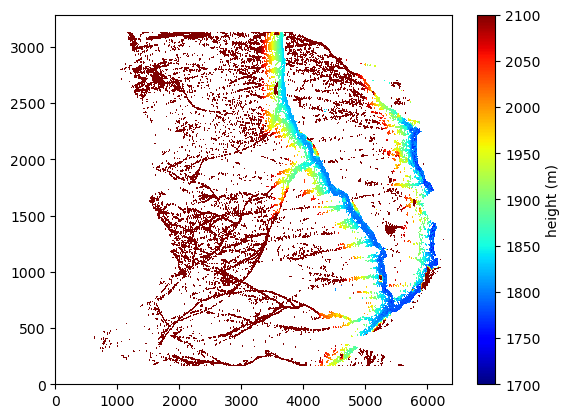

In [12]:
# height_ = np.flip(height, 1)  ## if left tile.
plt.imshow(height, interpolation='none', cmap='jet', aspect='auto', origin='lower')
plt.clim((1700, 2100))
plt.colorbar().set_label('height (m)')


(232389,)


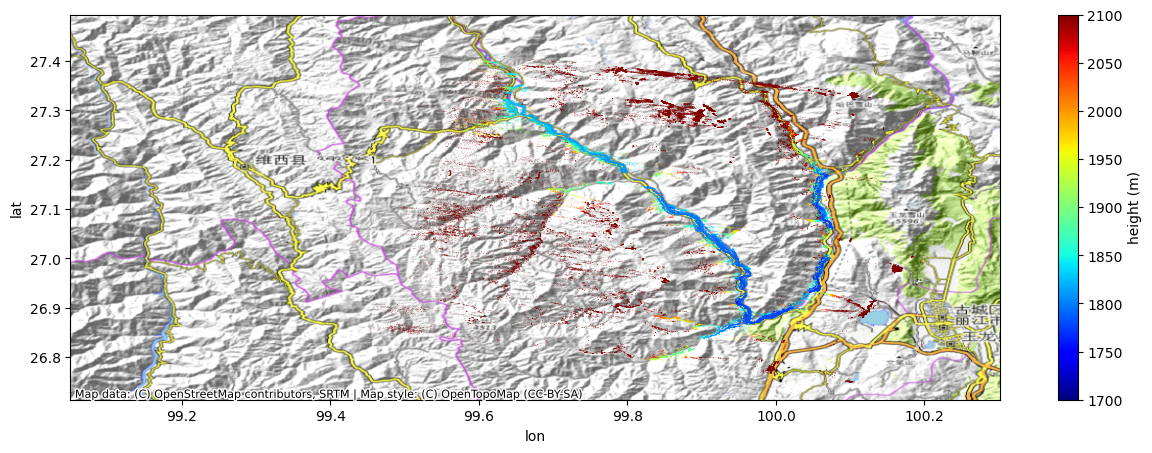

In [19]:
crs='EPSG:4326'
mask = np.where(np.logical_and(pixc_nc.classification > 2, pixc_nc.geolocation_qual <= 128))
print(mask[0].shape)
fig, ax = plt.subplots(figsize=(15,5))
scat = ax.scatter(x=pixc_nc.longitude[mask], y=pixc_nc.latitude[mask], c=pixc_nc.height[mask],
           s=0.1, edgecolor='none', cmap='jet', clim=(1700,2100))
cx.add_basemap(ax, crs=crs, source=cx.providers.OpenTopoMap, aspect='auto')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')

